In [6]:
%%capture
!pip install torch-geometric

In [7]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
import json
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch.optim as optim

In [8]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
file_paths = {
    "train_file_path": {
        "data_file_path": f"arc-agi_training_challenges.json",
        "target_file_path": f"arc-agi_training_solutions.json"
    },
    "val_file_path": {
        "data_file_path": f"arc-agi_evaluation_challenges.json",
        "target_file_path": f"arc-agi_evaluation_solutions.json"
    },
    "test_file_path": {
        "data_file_path": f"arc-agi_test_challenges.json"
    },
}
BATCH_SIZE = 128
CMAP = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
NORM = colors.Normalize(vmin=0, vmax=10)

In [9]:
print("ARC Dataset Class")
class ARCDataset:

    def __init__(self, train_file_path, val_file_path, test_file_path, batch_size):
        self.output = {
            "train_output":{},
            "val_output":{}
        }
        self.origin_data = {}
        self.train_data = self.extract_file(train_file_path, "train")
        self.val_data = self.extract_file(val_file_path, "val")
        self.test_data = self.extract_file(test_file_path, "test")
        self.batch_size = batch_size

    #   for dataset class, we just need the input and output data
    def extract_data(self, data):
        d = []
        for key, inps, targ, index in data:
            d.append([inps, targ])
        return d

    def train_dataset(self):
        return DataLoader(self.extract_data(self.train_data), batch_size=self.batch_size, shuffle=True)

    def val_dataset(self):
        return DataLoader(self.extract_data(self.val_data), batch_size=self.batch_size, shuffle=False)

    def test_dataset(self):
        return self.test_data

    #   extract json file
    def extract_file(self, file_path, type_data):
        data_file_path = file_path["data_file_path"]
        target_file_path = file_path["target_file_path"] if type_data != "test" else None
        if target_file_path != None:
            with open(target_file_path, 'r') as f:
                sol = json.load(f)
            for i in sol.keys():
                self.output[f"{type_data}_output"][i] = sol[i]
        return self.load_data(data_file_path, type_data)

    def load_data(self, file_path, type_data):
        with open(file_path, 'r') as f:
            data = json.load(f)
        self.origin_data[type_data] = data
        return self.parse_data(data, type_data)

    #   add '0' value for padding. each row must have 30 length
    def expand_data(self, data, data_append=0):
        return np.array([*data, *[data_append for _ in range(30 - len(data))]])

    #   add '0' or np.zeros(30) so the data shape become (30,30) (900 after flatten)
    def prep_data(self, data):
        data = np.array(data)

        ndata = []
        for d in data:
            ndata.append(self.expand_data(d, 0))
        return torch.tensor(self.expand_data(ndata, np.zeros(30)).flatten())

    # the input data idea is give the nn example_input + example_target + test_input so LSTM can remember what it should do
    def parse_data(self, data, type_data):
        ndata = []
        for key in tqdm(data.keys(), desc=type_data):
            train_data = data[key]['train']
            test_data = data[key]['test']
            train_temp, test_temp = [], []
            for trd in train_data:
                input_tensor = self.prep_data(trd['input'])
                output_tensor = self.prep_data(trd['output'])
                train_temp.append([
                    input_tensor,
                    output_tensor
                ])
            for i in range(len(test_data)):
                input_tensor = self.prep_data(test_data[i]['input'])
                if type_data != 'test' and key in self.output[f"{type_data}_output"]:
                    output_tensor = self.prep_data(self.output[f"{type_data}_output"][key][i])
                else:
                    output_tensor = np.zeros(900)
                test_temp.append([
                    input_tensor,
                    output_tensor
                ])
            for i, trd_1 in enumerate(train_temp):
                for j, tsd in enumerate(test_temp):
                    ndata.append([key, torch.tensor([*[*trd_1[0], 10, *trd_1[1]], 11, *tsd[0], 10]), torch.tensor(tsd[1]), j])

        print(f"Data type: {type_data}. Unique Puzzle: {len(data.keys())}. Parsing Puzzle: {len(ndata)}")
        return ndata

ARC Dataset Class


In [10]:
dataset = ARCDataset(**file_paths, batch_size=BATCH_SIZE)
train_data = dataset.train_dataset()
val_data = dataset.val_dataset()
test_data = dataset.test_dataset()

train:   0%|          | 0/400 [00:00<?, ?it/s]<ipython-input-9-ac1ae4949051>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ndata.append([key, torch.tensor([*[*trd_1[0], 10, *trd_1[1]], 11, *tsd[0], 10]), torch.tensor(tsd[1]), j])
train: 100%|██████████| 400/400 [00:25<00:00, 15.72it/s]


Data type: train. Unique Puzzle: 400. Parsing Puzzle: 1392


val: 100%|██████████| 400/400 [00:14<00:00, 27.20it/s]


Data type: val. Unique Puzzle: 400. Parsing Puzzle: 1456


test: 100%|██████████| 100/100 [00:03<00:00, 30.89it/s]

Data type: test. Unique Puzzle: 100. Parsing Puzzle: 351


In [11]:
print('LSTM Class')
class LSTM(nn.Module):
    def __init__(self, INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE):
        super().__init__()
        self.lstm = nn.LSTM(INPUT_SIZE, HIDDEN_SIZE, batch_first=True)
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE),
            nn.ReLU()
        )

    def forward(self, input_data):
        lstm_out, _ = self.lstm(input_data)
        predictions = self.fc(lstm_out)
        return predictions

LSTM Class


In [12]:
print('Training Class')
class Training:
    def __init__(self, model, train_loader, criterion, optimizer, device, loss = 100):
        self.model = model
        self.train_loader = train_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.loss = loss

    def _train_one(self, model, data, criterion, optimizer):
        # declare model for train mode
        model.train()

        # data is on cpu, transfer to gpu if gpu is available
        input_data, target = data
        input_data, target = input_data.to(self.device).float(), target.to(self.device).float()

        # get the output
        output = model(input_data)

        # calculate the loss
        loss = criterion(output, target)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    def _train_loop(self, model, train_loader, criterion, optimizer):
        model.train()
        history = {'train_loss': []}
        loss = self.loss
        epoch = 0
        patient = 0
        while True:
            epoch += 1
            train_loss = 0
            for data in train_loader:
                ls = self._train_one(model, data, criterion, optimizer)
                train_loss += ls
            train_loss /= len(train_loader)
            history['train_loss'].append(train_loss)

            print(f'\rEpoch : {epoch}, Loss: {train_loss:.5f}, Lowest Loss: {loss:.5f}, Patient: {patient}', end='')

            # if loss is smaller than before, save the model
            if train_loss < loss:
                loss = train_loss
                torch.save(model.state_dict(), 'model.pth')
                patient = 0
            else:
                patient += 1
            # I'm being greedy here. Sorry. if you dont like it, just remove 'and epoch > 2500'
            if epoch >= 5:
                break

        self.loss = loss
        return history

    def train(self):
        history = self._train_loop(self.model, self.train_loader, self.criterion, self.optimizer)
        self._plot_loss(history)

    def _plot_loss(self, history):
        plt.figure(figsize=(10, 5))
        plt.plot(history['train_loss'], 'o-', label='train_loss')
        plt.legend()
        plt.title('Loss Plot')
        plt.show()

Training Class


In [13]:
IN_DIM = len(test_data[1][1]) # 2703
OUT_DIM = 900
LATENT_DIM = 1800

Start training with train data
Epoch : 5, Loss: 1.23162, Lowest Loss: 1.24357, Patient: 0

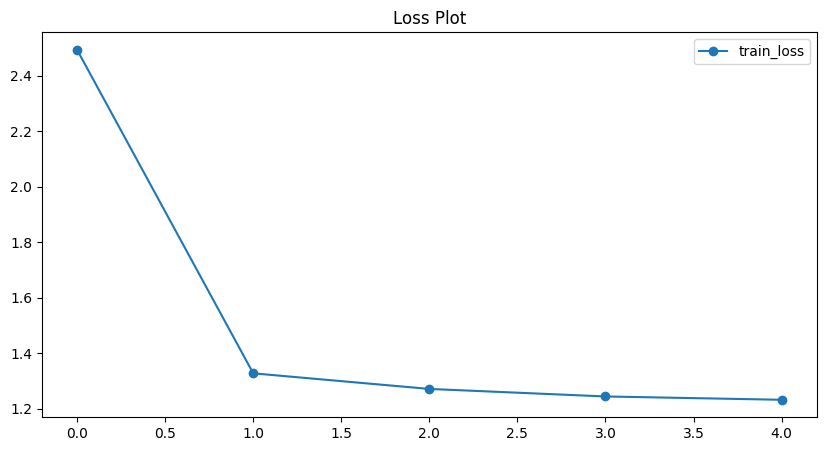

In [14]:
print("Start training with train data")
model = LSTM(IN_DIM, OUT_DIM, LATENT_DIM).to(DEVICE)
criterion = nn.MSELoss()
# load pre trained model
optimizer = optim.Adam(model.parameters(), lr=0.01)
training = Training(model, train_data, criterion, optimizer, DEVICE)
training.train()

In [81]:
class Prediction:

  def __init__(self, model, test_loader, device, criterion):
    self.model = model
    self.test_loader = test_loader
    self.device = device
    self.criterion = criterion

  def _predict_one(self,input_data, target, in_loop=0):
    self.model.eval()

    with torch.no_grad():
      output_data = self.model(input_data)

    ## if this method is called alone, let it visualize,the output of the model for one data point
    if in_loop == 0:
      input, output = self.prep_for_viz(input_data[0], output_data[0])
      fig, ax = plt.subplots(1, input.shape[0])
      for i in range(input.shape[0]):
        ax[i].imshow(input[i].reshape(30, 30), cmap=CMAP, norm=NORM)
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(output, cmap=CMAP, norm=NORM)
      ax[0].set_title('Output')
      ax[1].imshow(target[0].reshape(30, 30), cmap=CMAP, norm=NORM)
      ax[1].set_title('Target')
      plt.show()


    return criterion(output_data, target)

  def predict(self):
    val_loss = 0
    with torch.no_grad():
      for data in self.test_loader:
        input_data, target = data
        input_data, target = input_data.to(self.device).float(), target.to(self.device).float()
        val_loss += self._predict_one(input_data, target, in_loop=1)
      val_loss /= len(self.test_loader)
      print(f'Validation Loss: {val_loss:.5f}')


  def prep_for_viz(self, input, output):

    values_to_remove = torch.tensor([10,11])
    input = input[~torch.isin(input, values_to_remove)]
    input = input.reshape(3, 30, 30)

    return input, torch.round(output).reshape(30,30)





In [82]:
inp , out = next(iter(val_data))

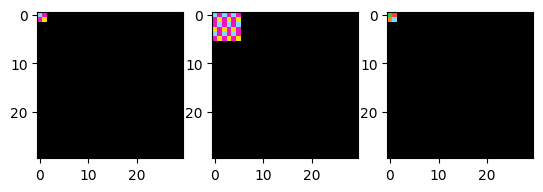

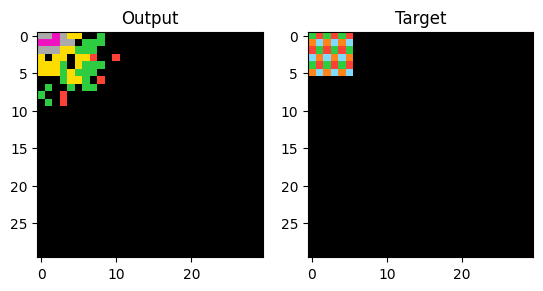

tensor(2.2842)

In [83]:
pred = Prediction(model, val_data, DEVICE, criterion)
pred._predict_one(inp.float(), out.float())